# Latent space analysis - more

In [158]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import interpolation as itp
from ipywidgets import interactive, interact, fixed
import ipywidgets as widgets
import pandas as pd
import pickle
plt.style.use('dark_background')

In [2]:
class Generator(nn.Module):
    def __init__(self, zdim=100, n_feature_maps=128):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #1x1
            nn.ConvTranspose2d(zdim, 8*n_feature_maps, 4, 1, 0, bias=False),
            nn.BatchNorm2d(8*n_feature_maps),
            nn.ReLU(True),
            #4x4
            nn.ConvTranspose2d(8*n_feature_maps, 4*n_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(4*n_feature_maps),
            nn.ReLU(True),
            #8x8
            nn.ConvTranspose2d(4*n_feature_maps, 2*n_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2*n_feature_maps),
            nn.ReLU(True),
            #16x16
            nn.ConvTranspose2d(2*n_feature_maps, n_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_feature_maps),
            nn.ReLU(True),
            #32x32
            nn.ConvTranspose2d(n_feature_maps, 3, 4, 2, 1, bias=False),
            #64x64
            nn.Tanh()
        )

    def  forward(self, x):
        return self.main(x)

In [9]:
G = Generator()
G.load_state_dict(torch.load('../paintings64_DCGAN_128_generator', map_location=lambda storage, loc: storage))
G.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d (100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d (1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d (512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d (256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d (128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [311]:
def sample_z(batch_size, zdim=100):
    return torch.FloatTensor(batch_size, zdim, 1, 1).normal_()

def show_result(G, z):
    if len(z.size()) < 4:
        z = z.view(1,-1,1,1)
    z = Variable(z, volatile=True)
    samples = G(z).data.numpy()
    samples = samples.transpose(0, 2, 3, 1)
    samples = (samples + 1) / 2
    
    image_per_line = 10
    
    n_samples = samples.shape[0]
    n_columns = min(n_samples, image_per_line)
    n_rows = 1 + n_samples//n_columns - (n_samples%n_columns==0)
    
    if n_samples == 1:
        plt.imshow(samples[0])
        return 
    
    fig, ax = plt.subplots(n_rows, n_columns, figsize=(18, n_rows*2))
    if n_samples <= n_columns:
        for j in range(n_columns):
            ax[j].get_xaxis().set_visible(False)
            ax[j].get_yaxis().set_visible(False)
            ax[j].cla()
            ax[j].imshow(samples[j])
    else:
        for i in range(n_rows):
            for j in range(n_columns):
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)
                ax[i, j].cla()
                k = i*image_per_line+j
                ax[i, j].imshow(samples[k])
    plt.tight_layout()
    plt.show()
    
def dot(x,y):
    return torch.dot(x.squeeze(), y.squeeze())

def grid(z):
    plt.imshow(z.numpy().reshape(10,10), cmap='seismic', vmin=-2, vmax=2)
    plt.axis('off')
    plt.colorbar()
    plt.show()
    
def show_interpolation(G, z1, z2, n, mode = 'slerp'):
    z1 = z1.view(1,-1,1,1)
    z2 = z2.view(1,-1,1,1)
    vals = np.linspace(0, 1, n)
    z = torch.Tensor([])
    for v in vals:
        if mode == 'lerp':
            res = itp.lerp(v, z1, z2)
        else:
            z1n = z1.numpy().reshape(-1)
            z2n = z2.numpy().reshape(-1)
            res = itp.slerp(v, z1n, z2n)
            res = torch.Tensor(res).view(1,-1,1,1)
            
        z = torch.cat([z, res],0)
        
    show_result(G, z)
    
def norm(z):
    return np.linalg.norm(z)

In [19]:
d = pickle.load(open('color_vectors.p', 'rb'))
d.keys()

dict_keys(['red', 'blue', 'dark', 'light', 'yellow', 'purple'])

In [20]:
z_red = d['red']
z_blue = d['blue']
z_dark = d['dark']
z_yellow = d['yellow']
z_purple = d['purple']
z_light = d['light']

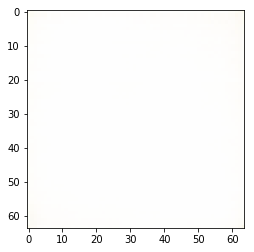

In [54]:
show_result(G, 2*z_light)

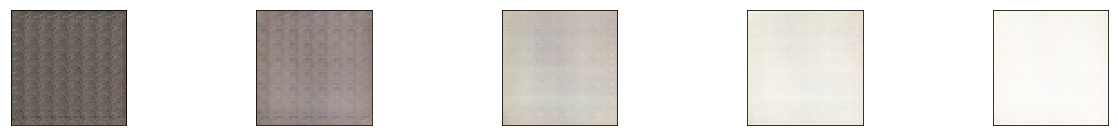

In [84]:
show_interpolation(G,z,5*z,5,'lerp')

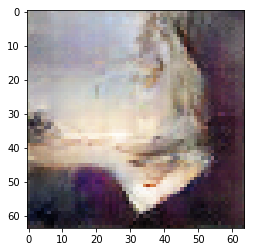

In [85]:
z = sample_z(1)
show_result(G, z)

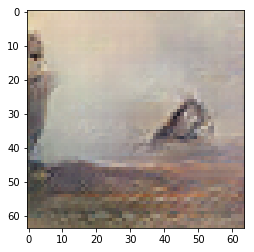

In [120]:
z = sample_z(1)
show_result(G,z)

In [129]:
u_light = z_light / float(np.linalg.norm(z_light))
u_dark = u_red = z_dark / float(np.linalg.norm(z_dark))
u_red = z_red / float(np.linalg.norm(z_red))
u_blue = z_blue / float(np.linalg.norm(z_blue))
u_yellow = z_yellow / float(np.linalg.norm(z_yellow))

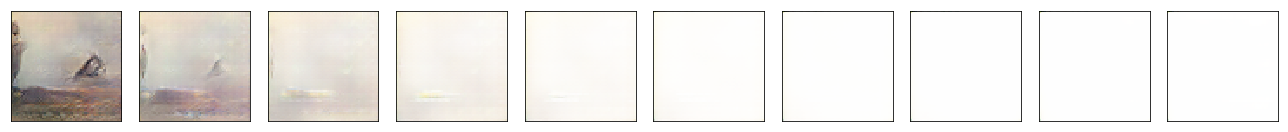

In [121]:
show_interpolation(G, z,z+ 10*u_light,10)

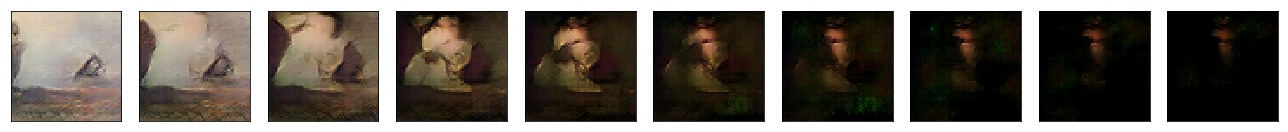

In [125]:
show_interpolation(G,z,z+10*u_dark,10)

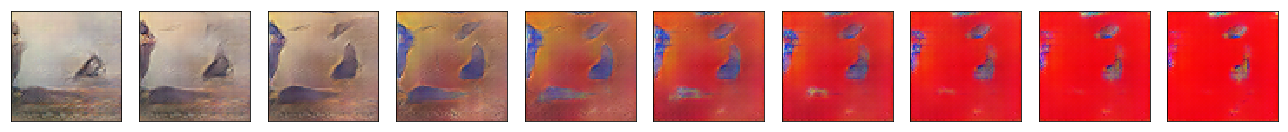

In [128]:
show_interpolation(G,z,z+10*u_red,10)

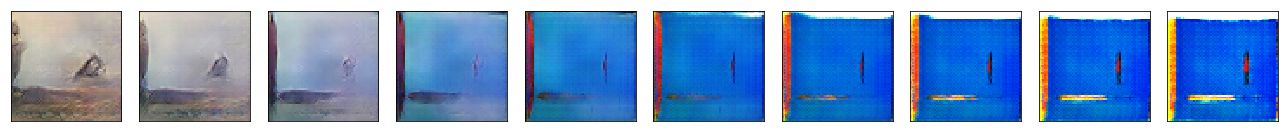

In [130]:
show_interpolation(G,z,z+10*u_blue,10)

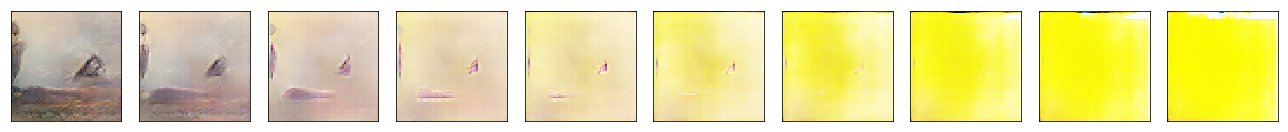

In [131]:
show_interpolation(G,z,z+10*u_yellow,10)

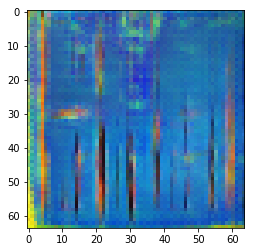

In [136]:
b = batch[15].view(1,-1,1,1)
show_result(G,b)

In [150]:
z_white = 10*u_light

In [148]:
np.linalg.norm(z)

11.384

In [147]:
np.linalg.norm(10*u_light)

9.999999

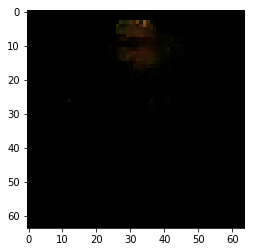

In [152]:
show_result(G, 10*u_dark)

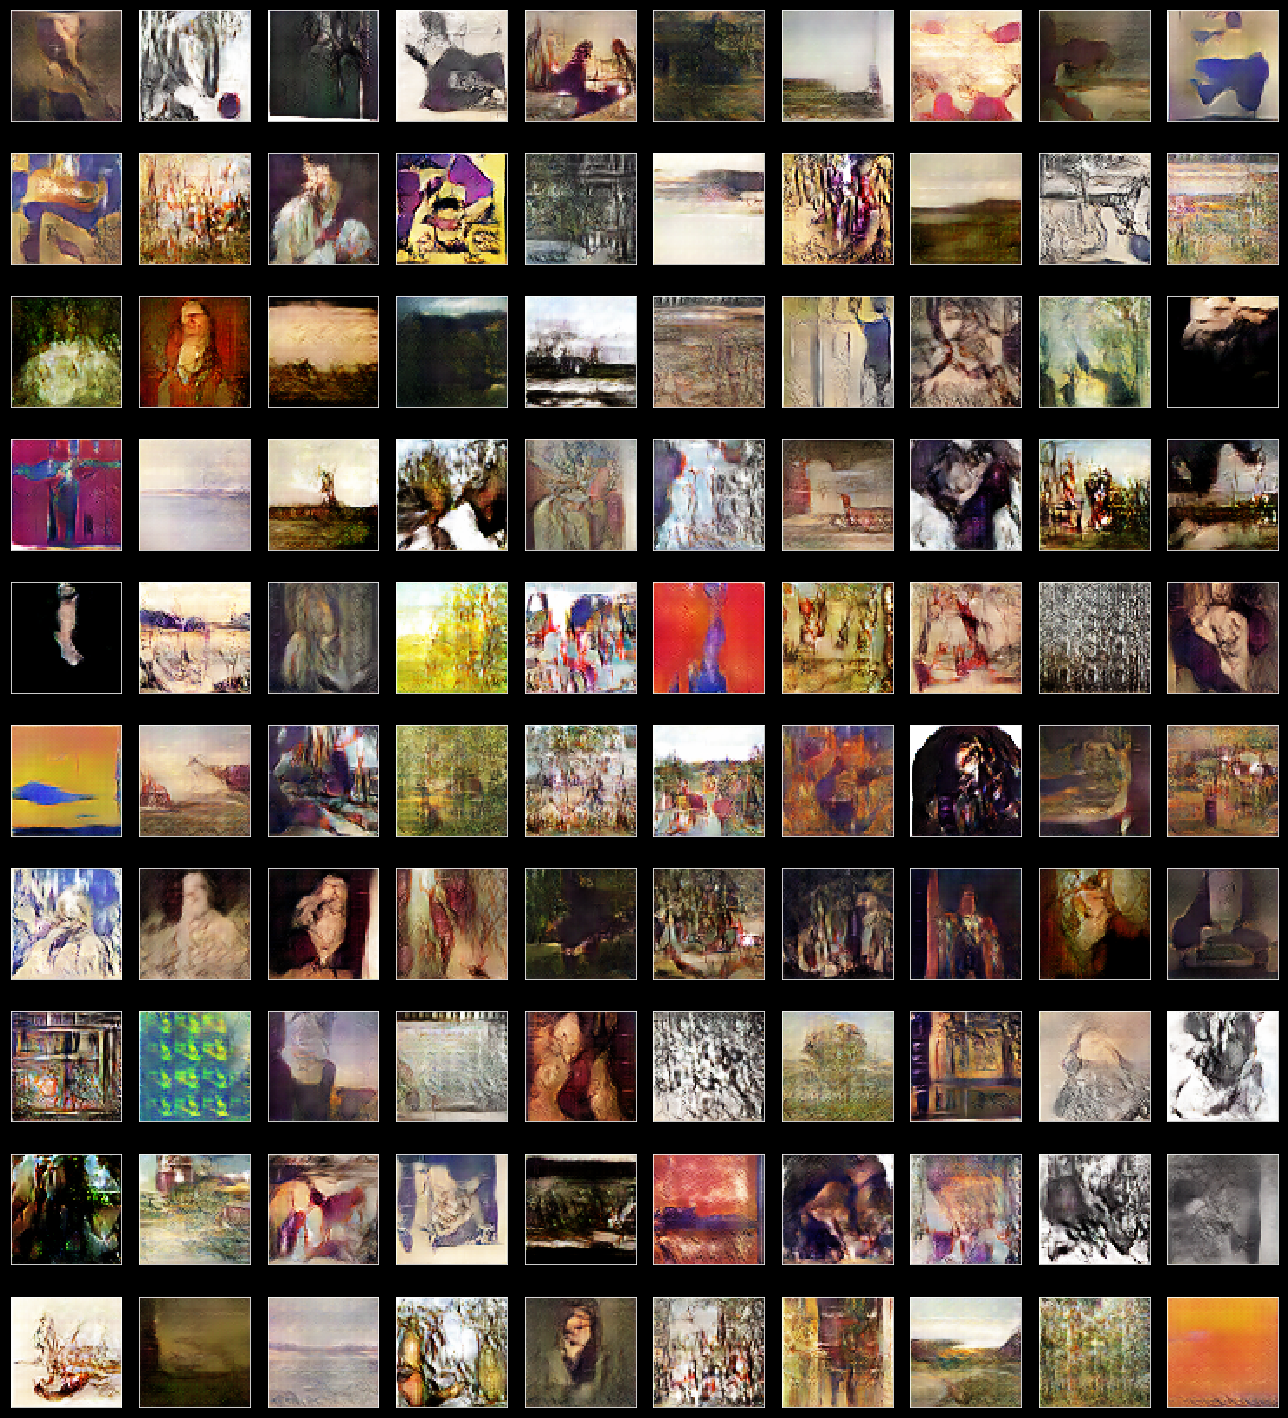

In [593]:
batch4 = sample_z(100)
show_result(G,batch4)

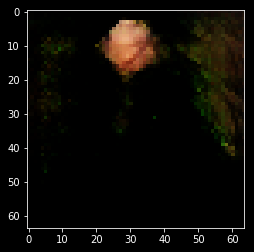

In [260]:
show_result(G,batch3[6])

In [195]:
def mean(indices,vec):
    s = 0
    for i in indices:
        s += vec[i]
    return s / len(indices)

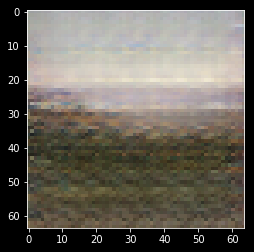

In [199]:
ls1 = mean([0,3,23,31,45,49,98],batch2)
ls2 = mean([3,13,18,91,96],batch)
ls = 7*ls1 + 5*ls2
ls /= 12
show_result(G,ls)

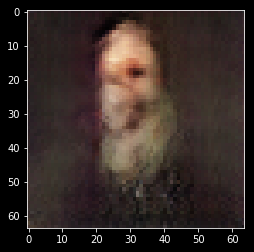

In [289]:
pt1 = mean([33,60],batch2)
pt2 = mean([26,45,48,52,72],batch3)
pt = batch[70].view(1,-1,1,1) + 2*pt1 + 5*pt2
pt /= 8
show_result(G,pt)

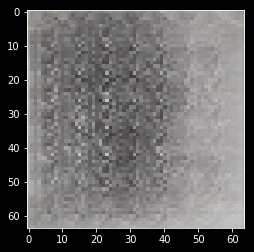

In [333]:
sketch1 = mean([35,35,40],batch2)
sketch2 = mean([10,19,45,87,93],batch)
sketch = 3*sketch1 + 5*sketch2
sketch /= 8
show_result(G,sketch)

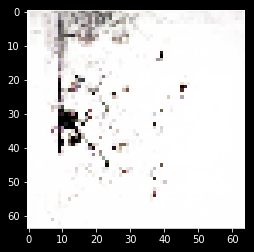

In [537]:
show_result(G,sketch)

In [553]:
torch.save(z, 'z_example_remove_red.p')

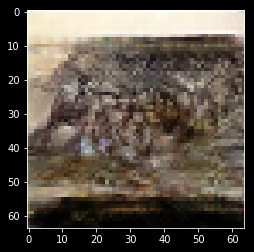

In [618]:
z = sample_z(1)
#z = torch.load('z_example_both.p')
show_result(G,z)

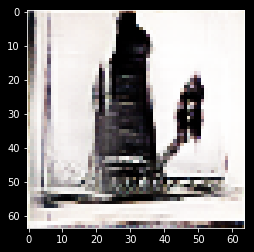

In [605]:
show_result(G,z+sketch)

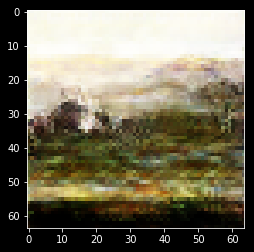

In [619]:
show_result(G,z+ls)

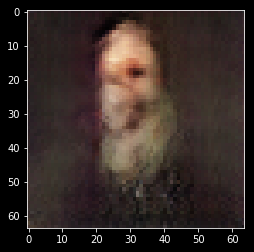

In [615]:
show_result(G,pt)

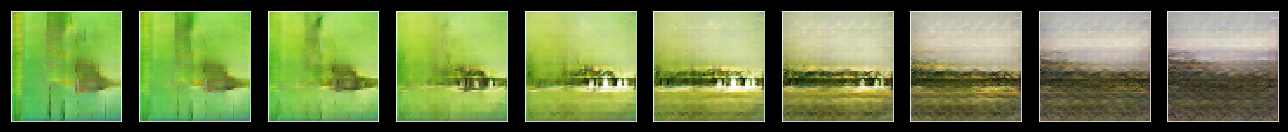

In [212]:
show_interpolation(G,z,ls,10,'slerp')

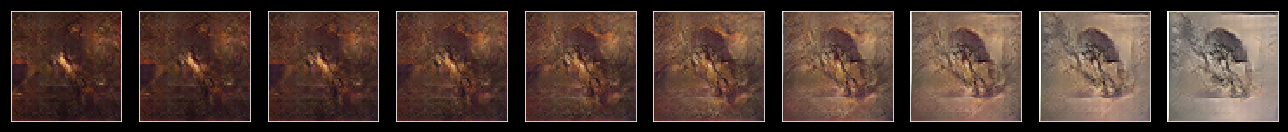

In [531]:
show_interpolation(G,z-sketch,z+sketch,10,'slerp')

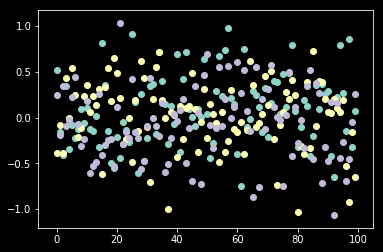

In [527]:
xs = np.arange(100)
plt.scatter(xs,pt.squeeze().numpy())
plt.scatter(xs,ls.squeeze().numpy())
plt.scatter(xs,sketch.squeeze().numpy())